<a href="https://colab.research.google.com/github/Kogo0813/Windroad8/blob/main/TPUver_windpredict_data_from_s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!echo $COLAB_TPU_ADDR #코랩에서 런타임->런타임 유형 변경 -> TPU로 변경

10.91.16.114:8470


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from osgeo import gdal

# TPU gRPC 접근 URI
TPU_PATH = f"grpc://{os.environ['COLAB_TPU_ADDR']}"
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=TPU_PATH)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

In [3]:
strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive
%cd MyDrive
%cd data_from_s

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive
/content/drive/MyDrive
/content/drive/MyDrive/data_from_s


In [89]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Dense, Flatten
import tensorflow.keras.backend as K
from keras.utils import get_custom_objects

with strategy.scope():
  def r2_metric(y_true, y_pred):
      SS_res =  K.sum(K.square(y_true - y_pred))
      SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
      return (1 - SS_res/(SS_tot + K.epsilon()))

  get_custom_objects().update({'r2_metric': r2_metric})
  width = 80
  height = 60
  channels = 7
  model = Sequential([
     keras.Input(shape=(None,height,width,channels)),
      layers.ConvLSTM2D(filters=2, kernel_size=(3, 3), padding="same", return_sequences=True),
  ])
  # 모델 컴파일
  model.compile(optimizer='adam', loss='mse',metrics='r2_metric')
  model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_31 (ConvLSTM2D)  (None, None, 60, 80, 2)  656       
                                                                 
Total params: 656
Trainable params: 656
Non-trainable params: 0
_________________________________________________________________


In [68]:
#from skimage.measure import block_reduce 다운샘플링보다 잘라쓰는게 나을것 같에서 중간에이미지 잘라서 썻습니다.
#이거 돌아가는데 약 3시간 30분 걸립니다 참고하세요
from sklearn.preprocessing import MinMaxScaler # 입력 정규화 Min-Max 스케일링 사용


X = []
Y = []
for i in range(1, 13):
  for h in range(1, 4):
    for s in range(0,6):
      for d in range(0, 360, 60):
        if i==3 and h==1 and s ==3 : 
          continue
        if i==3 and h==3 and s ==1 and d==300: 
          continue
        if i==3 and h==3 and s ==5 and d==120: 
          continue
        if i==8 and h==1 and s ==3 and d==120: 
          continue
        if i==9 and h==2 and s ==3 and d==300: 
          continue ## 이 파일들 이상해서 그냥 안쓸려고 합니다.
        height = np.full((60,80),(h-1)/2) #지역풍 높이는 1부터 3까지 있으므로 이렇게 정규화시킴
        speed = np.full((60,80), s/5) #속도도 마찬가지 0부터 5까지
        direction = np.full((60,80),d/300) # 방향 0부터 300까지
        uz_zero = np.full((60,80),0)
        vz_zero = np.full((60,80),0)
        scaler = MinMaxScaler()
        landuse = gdal.Open("입력데이터/"+"Landuse_"+"{:006d}".format(i)+".tif")
        landuse = np.array(landuse.GetRasterBand(1).ReadAsArray())
        terrain = gdal.Open("입력데이터/"+"Terrain_"+"{:006d}".format(i)+".tif")
        terrain = np.array(terrain.GetRasterBand(1).ReadAsArray())
        landuse = landuse[570:630,710:790]
        terrain = terrain[570:630,710:790]
        terrain = scaler.fit_transform(terrain)
        landuse = scaler.fit_transform(landuse)
        stacked_layer_input = []
        stacked_layer_input.append(np.dstack((uz_zero,vz_zero,landuse,terrain,direction,speed,height)))
        for j in range(360, 3960, 360):
            uz = np.loadtxt("0000" +"{:02d}".format(i) +"_R010_H0"+ str(h) +".0_S00"+str(s)+".00_D"+"{:003d}".format(d)+'_uz00'+"{:04d}".format(j)+'.dw', skiprows = 8, dtype = 'int', encoding='latin-1')
            vz = np.loadtxt("0000" +"{:02d}".format(i) +"_R010_H0"+ str(h) +".0_S00"+str(s)+".00_D"+"{:003d}".format(d)+'_vz00'+"{:04d}".format(j)+'.dw', skiprows = 8, dtype = 'int', encoding='latin-1')
            uz = uz[570:630,710:790]
            vz = vz[570:630,710:790]
            uz = scaler.fit_transform(uz)
            vz = scaler.fit_transform(vz)
            if j == 3600:
              stacked_layer_output = np.dstack((uz,vz))
            else:
              stacked_layer_input.append(np.dstack((uz,vz,landuse,terrain,direction,speed,height)))
        X.append(stacked_layer_input)
        Y.append(stacked_layer_output)


In [70]:
X = np.array(X)
Y = np.array(Y)
Y = Y.reshape(1286,1,60,80,2)
Y.shape

(1286, 1, 60, 80, 2)

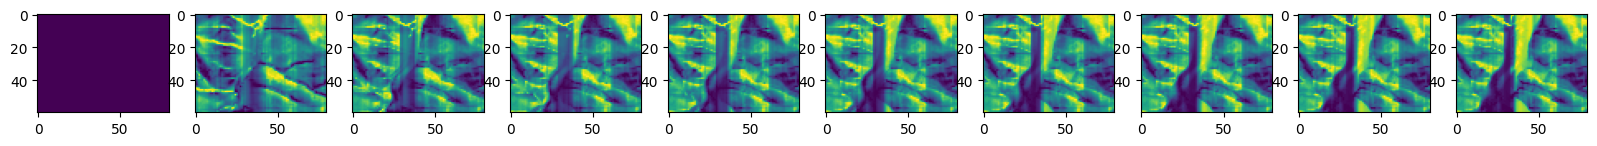

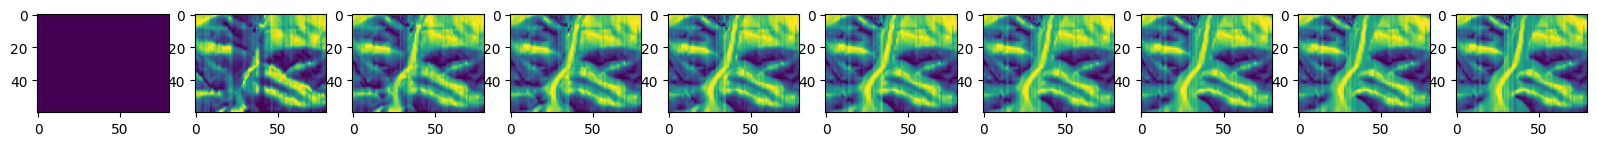

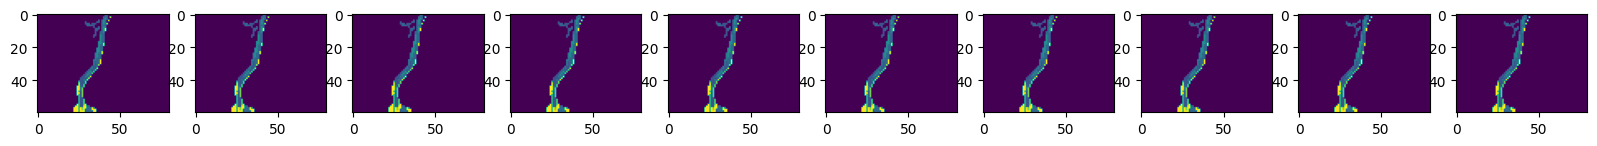

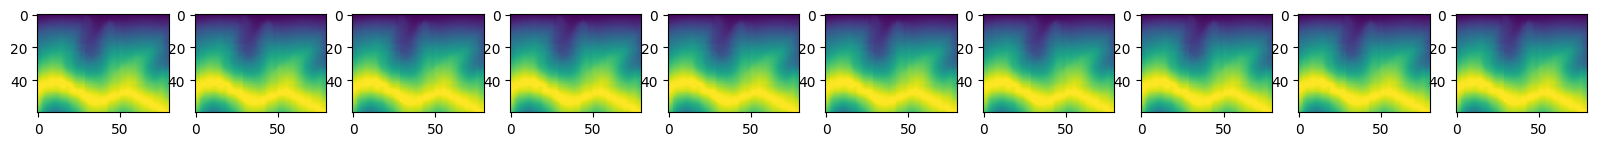

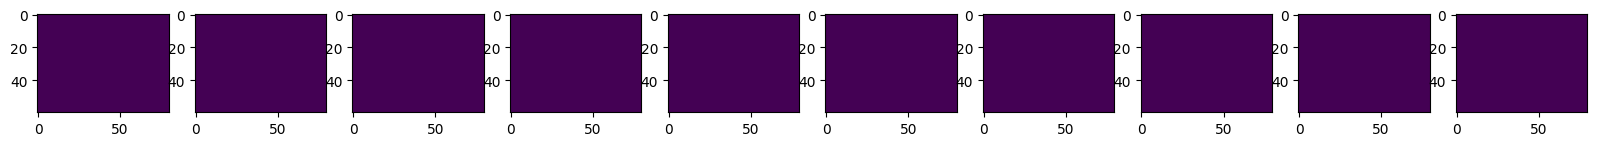

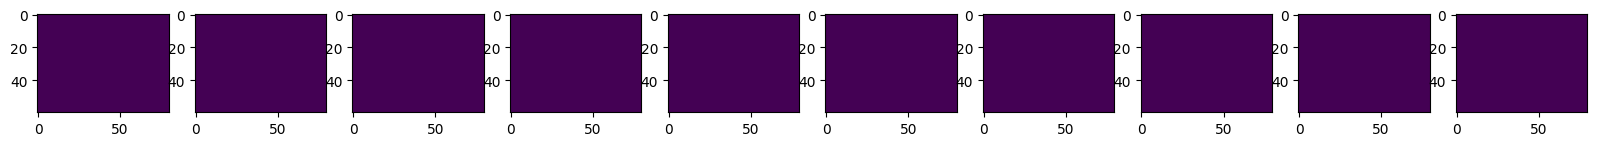

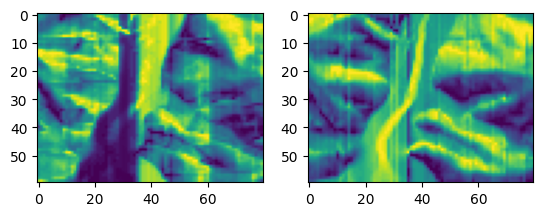

In [71]:
plt.figure(figsize=(20,30))  #잘라낸 이미지 360초 단위 9번 동안의 변화 시각화
for i in range(X.shape[1]): #uz
    plt.subplot(1,10,i+1)
    plt.imshow(X[3,i,:,:,0])
plt.show()
plt.figure(figsize=(20,30))  #잘라낸 이미지 360초 단위 9번 동안의 변화 시각화
for i in range(X.shape[1]): #vz
    plt.subplot(1,10,i+1)
    plt.imshow(X[3,i,:,:,1])
plt.show()
plt.figure(figsize=(20,30)) 
for i in range(X.shape[1]): #landuse
    plt.subplot(1,10,i+1)
    plt.imshow(X[3,i,:,:,2])
plt.show()
plt.figure(figsize=(20,30)) 
for i in range(X.shape[1]): #terrain
    plt.subplot(1,10,i+1)
    plt.imshow(X[3,i,:,:,3])
plt.show()
plt.figure(figsize=(20,30)) 

for i in range(2): #정답값이 되는 10번쨰 uz,vz
    plt.subplot(1,2,i+1)
    plt.imshow(Y[3,0,:,:,i])
plt.show()

In [ ]:
Y_uz= Y[:,:,:,:,0]
Y_uz = Y_uz.reshape(1286,1,60,80,1)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-93-c540d7ef4395>", line 2, in <cell line: 2>
    Y_uz.shape = np.reshape((1286,1,60,80,1))
  File "<__array_function__ internals>", line 198, in reshape
TypeError: reshape() missing 1 required positional argument: 'newshape'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerfra

In [90]:
from tensorflow.keras.callbacks import EarlyStopping
with strategy.scope():
  early_stop = EarlyStopping(monitor='val_loss',min_delta=0.0001, patience=3, verbose=1, mode='min',restore_best_weights=True)
  history = model.fit(x=X, y=Y, validation_split=0.2, epochs=400, callbacks=[early_stop])

Epoch 1/400
33/33 [==============================] - 31s 736ms/step - loss: 0.3531 - r2_metric: -42.9343 - val_loss: 0.1884 - val_r2_metric: -20.8115
Epoch 2/400
33/33 [==============================] - 6s 180ms/step - loss: 0.1596 - r2_metric: -18.9121 - val_loss: 0.1326 - val_r2_metric: -14.3405
Epoch 3/400
33/33 [==============================] - 6s 177ms/step - loss: 0.1171 - r2_metric: -13.6244 - val_loss: 0.1025 - val_r2_metric: -10.8644
Epoch 4/400
33/33 [==============================] - 6s 184ms/step - loss: 0.0947 - r2_metric: -10.8418 - val_loss: 0.0882 - val_r2_metric: -9.2118
Epoch 5/400
33/33 [==============================] - 6s 178ms/step - loss: 0.0841 - r2_metric: -9.5186 - val_loss: 0.0813 - val_r2_metric: -8.4185
Epoch 6/400
33/33 [==============================] - 6s 184ms/step - loss: 0.0785 - r2_metric: -8.8129 - val_loss: 0.0771 - val_r2_metric: -7.9388
Epoch 7/400
33/33 [==============================] - 6s 180ms/step - loss: 0.0747 - r2_metric: -8.3385 - val_l